# Importing Libraries

In [4]:
import numpy as np
import pandas as pd 
import random as rn

# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Chart
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import glob
from pathlib import Path

from skimage import color, exposure
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import os
import cv2

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


#Loading data

In [5]:
cd drive/MyDrive/Colab Notebooks/Covid_detection

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/Covid_detection'
/content/drive/MyDrive/Colab Notebooks/Covid_detection


In [6]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Covid_detection'

In [7]:
pneumonia_bacterial = np.load('Data/pneumonia_bacterial.npy')
covid = np.load('Data/covid.npy')
normal = np.load('Data/normal.npy')
pneumonia_viral = np.load('Data/pneumonia_viral.npy')

In [8]:
pneumonia_bacterial = pneumonia_bacterial.reshape(-1, 256*256)
covid = covid.reshape(-1, 256*256)
normal = normal.reshape(-1, 256*256)
pneumonia_viral = pneumonia_viral.reshape(-1, 256*256)

In [9]:
def f(x):
    if x == 0:
        return 'normal'
    elif x == 1:
        return 'pneumonia_bacterial'
    elif x == 2:
        return 'pneumonia_viral'
    elif x == 3:
        return 'covid'

In [10]:
df0 = pd.DataFrame([(img,0) for img in normal],columns=['img', 'label'])
df1 = pd.DataFrame([(img,1) for img in pneumonia_bacterial],columns=['img', 'label'])
df2 = pd.DataFrame([(img,2) for img in pneumonia_viral],columns=['img', 'label'])
df3 = pd.DataFrame([(img,3) for img in covid],columns=['img', 'label'])

sizes = [pneumonia_bacterial.shape[0], covid.shape[0], normal.shape[0], pneumonia_viral.shape[0]]
names = ['pneumonia_bacterial', 'covid', 'normal', 'pneumonia_viral']
del pneumonia_bacterial, normal, covid, pneumonia_viral

In [11]:
df = pd.concat((df0,df1,df2,df3)).reset_index()
del df0, df1, df2, df3

In [12]:
X = np.stack(df['img'])
y = df['label']
del df

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.01, random_state=seed)
del X, y

# Exploratory Data Analysis

In [30]:
def Show_example_image(X, y):
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(X[idx].reshape(256,256),cmap='gray')
        plt.title("{}".format(f(y[idx])))
        
    plt.tight_layout()

## All Data

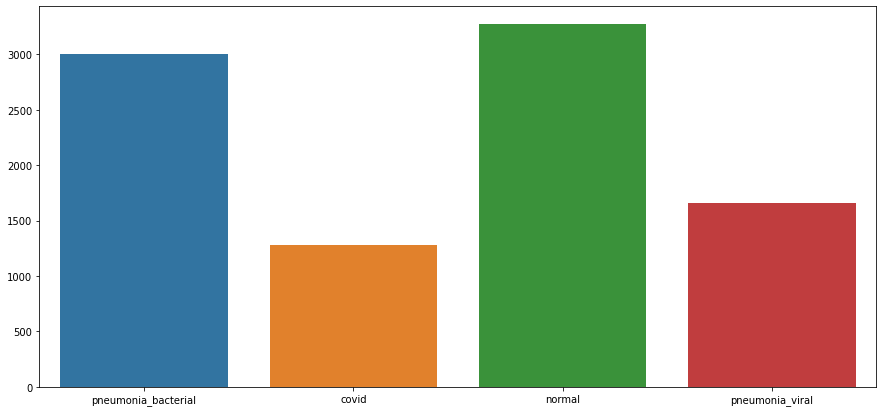

In [23]:
plt.figure(figsize=(15,7))
sns.barplot(x=names, y=sizes);

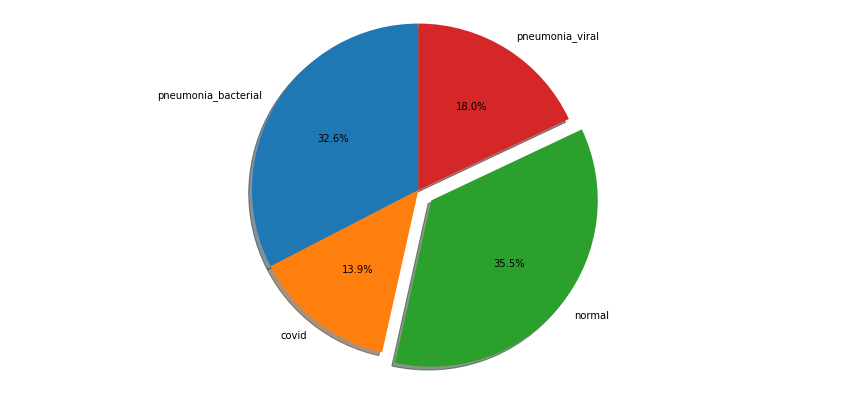

In [24]:
plt.figure(figsize=(15,7))

explode = (0, 0, 0.1, 0)
plt.pie(sizes, explode=explode, labels = names, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal') 
plt.show()

## Train data

In [81]:
def Show_example_image(X, y):
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow((X[idx].reshape(256,256)),cmap='gray')
        plt.title("{}".format(f(y.iloc[idx])))
        
    plt.tight_layout()

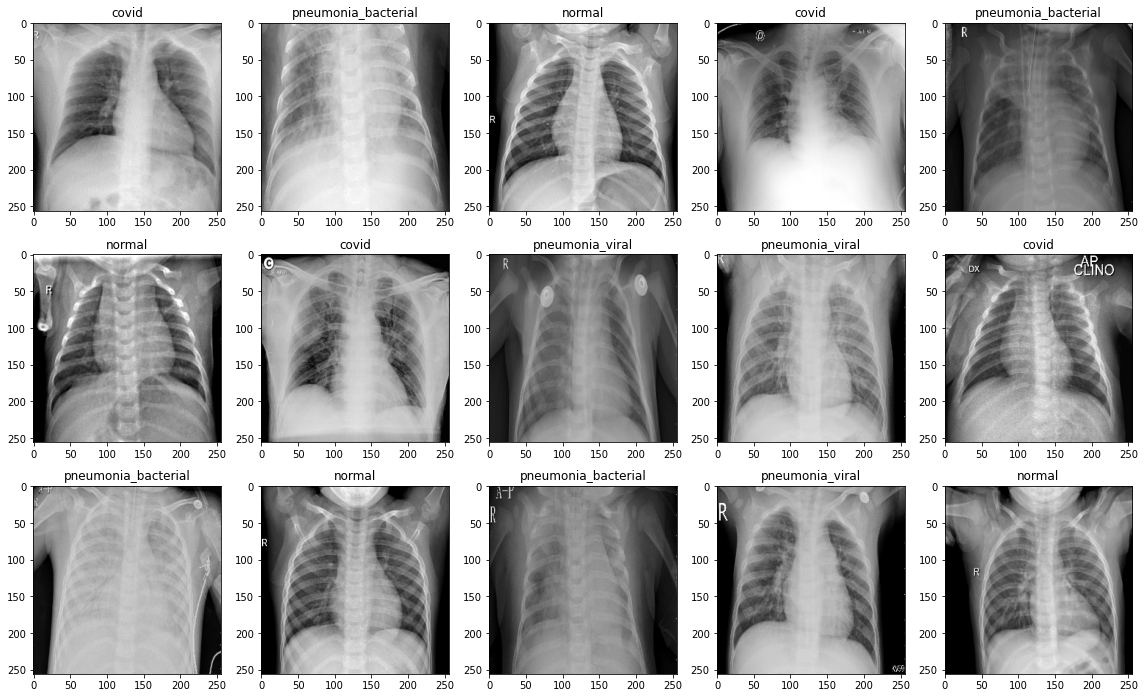

In [82]:
Show_example_image(X_train, y_train)

In [83]:
val, cnt = np.unique(y_train,return_counts=True)

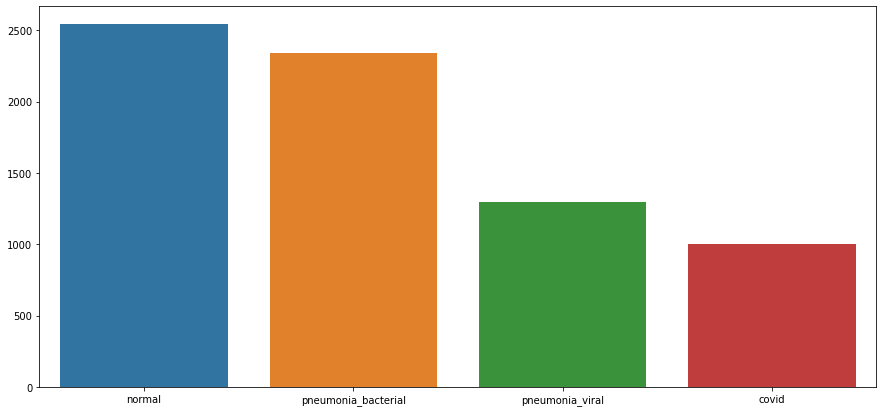

In [84]:
plt.figure(figsize=(15,7))
sns.barplot(x = [f(x) for x in val], y = cnt);

## Test data

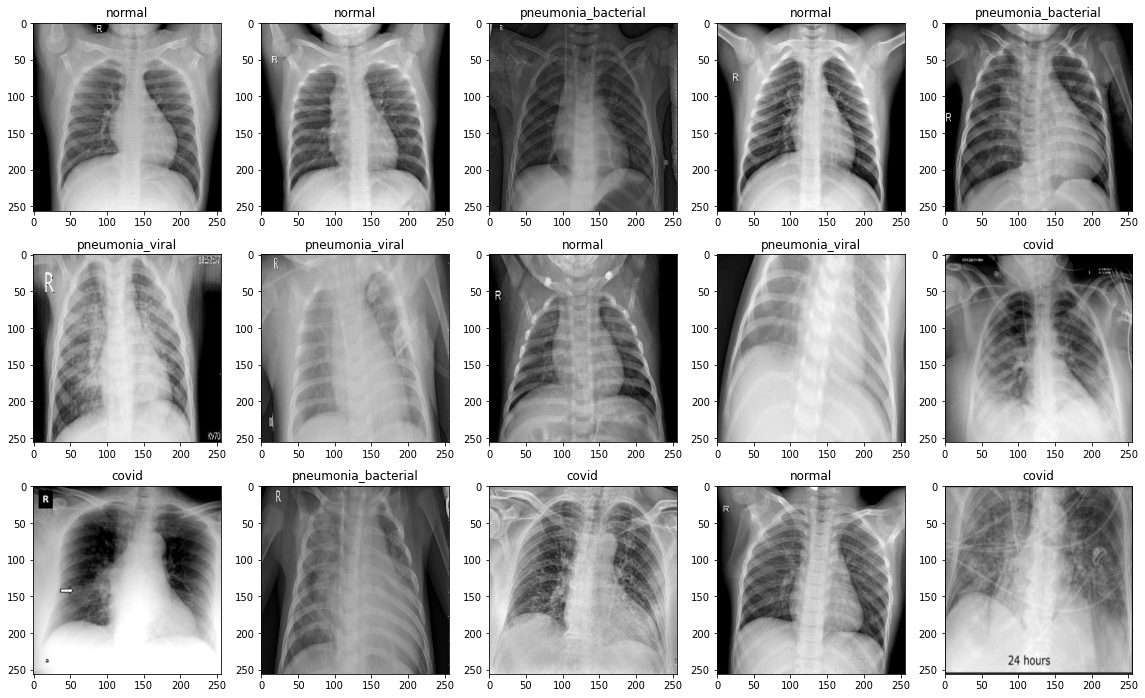

In [85]:
Show_example_image(X_test, y_test)

In [86]:
val, cnt = np.unique(y_test,return_counts=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


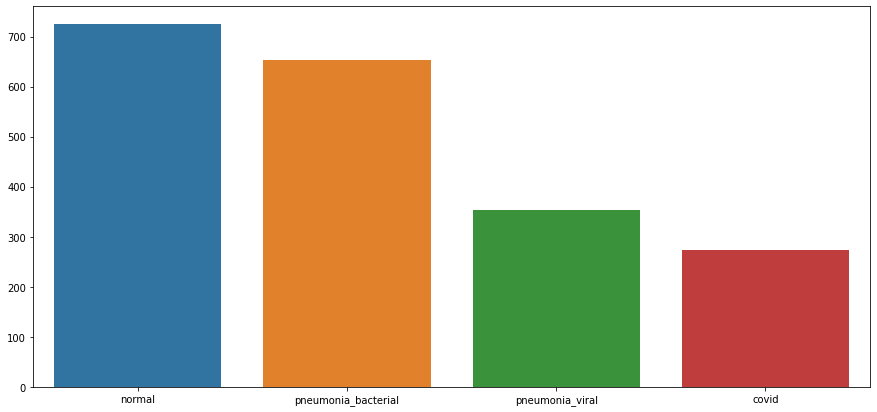

In [87]:
plt.figure(figsize=(15,7))
sns.barplot([f(x) for x in val], cnt);

## Validation data

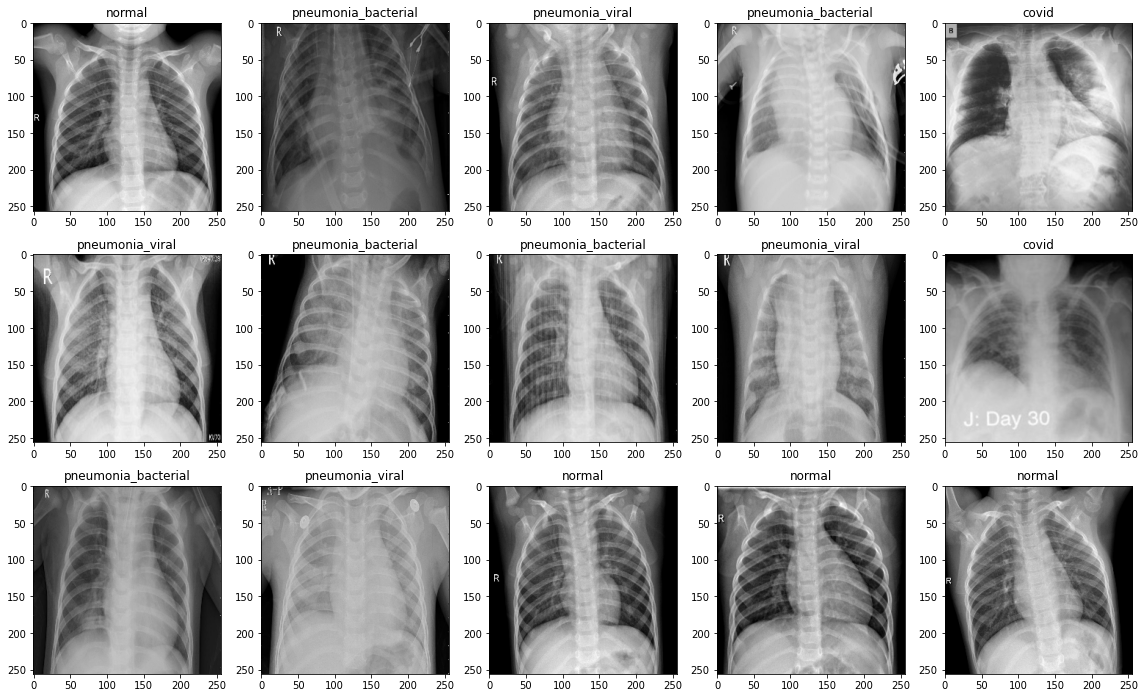

In [88]:
Show_example_image(X_val, y_val)

In [89]:
val, cnt = np.unique(y_val,return_counts=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


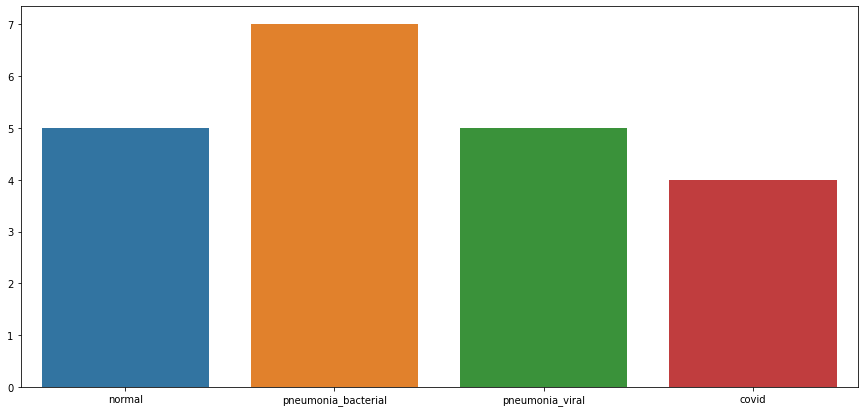

In [90]:
plt.figure(figsize=(15,7))
sns.barplot([f(x) for x in val], cnt);

# MLP

## Preprocessing

In [91]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [92]:
num_pixels = X_train.shape[1]
num_pixels

65536

In [93]:
num_classes = y_train.shape[1]
num_classes

4

In [94]:
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

In [95]:
def get_callback(num):
    return [ 
        EarlyStopping(monitor = 'loss', patience = 6), 
        ReduceLROnPlateau(monitor = 'loss', patience = 3), 
        ModelCheckpoint('models/model.best{}.hdf5'.format(num),monitor='loss', save_best_only=True) # saving the best model
    ]

## First model

In [96]:
callbacks = get_callback(1)

In [97]:
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(512, input_dim = num_pixels, activation='relu'),
        
        Dropout(0.3),

        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [98]:
model = get_mlp()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               33554944  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 33,556,996
Trainable params: 33,556,996
Non-trainable params: 0
_________________________________________________________________


In [99]:
learning_history = model.fit(X_train, y_train,
          batch_size = 128, epochs = 60, verbose = 2,
          callbacks = callbacks,
          validation_data=(X_test, y_test));

Epoch 1/60
57/57 - 6s - loss: 12.3214 - accuracy: 0.5323 - val_loss: 0.8131 - val_accuracy: 0.5686
Epoch 2/60
57/57 - 3s - loss: 0.7809 - accuracy: 0.6937 - val_loss: 0.6145 - val_accuracy: 0.7541
Epoch 3/60
57/57 - 7s - loss: 0.6527 - accuracy: 0.7406 - val_loss: 0.5720 - val_accuracy: 0.7641
Epoch 4/60
57/57 - 10s - loss: 0.6161 - accuracy: 0.7570 - val_loss: 0.5672 - val_accuracy: 0.7601
Epoch 5/60
57/57 - 10s - loss: 0.6151 - accuracy: 0.7541 - val_loss: 0.5213 - val_accuracy: 0.7925
Epoch 6/60
57/57 - 10s - loss: 0.5894 - accuracy: 0.7563 - val_loss: 0.5452 - val_accuracy: 0.7791
Epoch 7/60
57/57 - 2s - loss: 0.6001 - accuracy: 0.7563 - val_loss: 0.5046 - val_accuracy: 0.7945
Epoch 8/60
57/57 - 6s - loss: 0.5662 - accuracy: 0.7698 - val_loss: 0.5080 - val_accuracy: 0.7776
Epoch 9/60
57/57 - 2s - loss: 0.5709 - accuracy: 0.7671 - val_loss: 0.5527 - val_accuracy: 0.7791
Epoch 10/60
57/57 - 2s - loss: 0.5882 - accuracy: 0.7549 - val_loss: 0.5059 - val_accuracy: 0.7850
Epoch 11/60
57/

In [100]:
model = load_model('models/model.best1.hdf5')

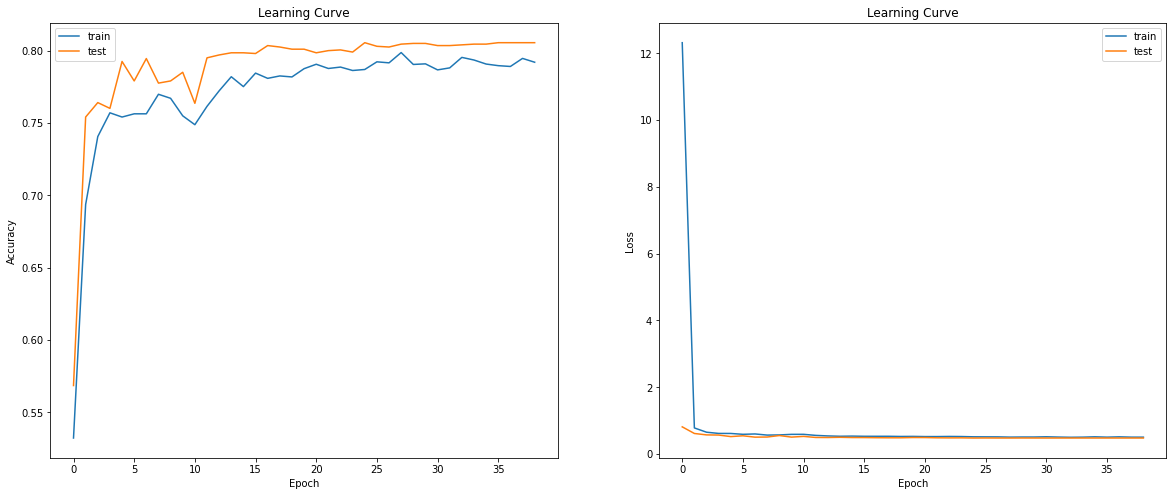

In [101]:
draw_learning_curve(learning_history)

# Evalute model on train data

In [102]:
Result = pd.DataFrame()

In [103]:
scores = []

In [104]:
score = model.evaluate(X_train, y_train, verbose = 0)
print('Train loss: {}%'.format(score[0] * 100))
print('Train accuracy: {}%'.format(score[1] * 100))

print("Train Error: %.2f%%" % (100 - score[1] * 100))

Train loss: 43.57718825340271%
Train accuracy: 82.08020329475403%
Train Error: 17.92%


In [105]:
score_train = {'Train loss':score[0] * 100, 'Train accuracy':score[1] * 100, 'Train Error':(100 - score[1] * 100)}

In [106]:
scores = score_train

# Evalute model on test data

In [107]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("Test Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 47.83976078033447%
Test accuracy: 80.39900064468384%
Test Error: 19.60%


In [108]:
score_test = {'Test loss':score[0] * 100, 'Test accuracy':score[1] * 100, 'Test Error':(100 - score[1] * 100)}

In [109]:
scores.update(score_test)

# Evalute model on validation data

In [110]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Valid loss: {}%'.format(score[0] * 100))
print('Valid accuracy: {}%'.format(score[1] * 100))

print("Valid Error: %.2f%%" % (100 - score[1] * 100))

Valid loss: 43.90614032745361%
Valid accuracy: 76.1904776096344%
Valid Error: 23.81%


In [111]:
score_valid = {'Valid loss':score[0] * 100, 'Valid accuracy':score[1] * 100, 'Valid Error':(100 - score[1] * 100)}

In [112]:
scores.update(score_valid)

# Adding the result to the table

In [113]:
scores

{'Test Error': 19.600999355316162,
 'Test accuracy': 80.39900064468384,
 'Test loss': 47.83976078033447,
 'Train Error': 17.91979670524597,
 'Train accuracy': 82.08020329475403,
 'Train loss': 43.57718825340271,
 'Valid Error': 23.8095223903656,
 'Valid accuracy': 76.1904776096344,
 'Valid loss': 43.90614032745361}

In [114]:
score = pd.DataFrame(scores,index = ['Simple MLP'])

In [115]:
score.to_csv('models/score.csv')

In [116]:
score

,Train loss,Train accuracy,Train Error,Test loss,Test accuracy,Test Error,Valid loss,Valid accuracy,Valid Error
Simple MLP,43.577188,82.080203,17.919797,47.839761,80.399001,19.600999,43.90614,76.190478,23.809522
